# GP Regression Demo
This demonstration covers the basics of a supervised learning problem with gptorch:
* Defining a model
* Training the model
* Predicting with the model

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

In [2]:
from gptorch.models.gpr import GPR
from gptorch.models.sparse_gpr import VFE
from gptorch import kernels
from gptorch.util import TensorType
from gptorch import mean_functions

In [3]:
from gptorch import kernels

## Ground truth and training data
We'll try to model a simple one-dimensional sinusoid.

In [4]:
def f(x):
    return np.sin(2. * np.pi * x) + np.cos(3.5 * np.pi * x) - 3.0 * x + 5.0

In [5]:
n = 100
x = np.linspace(0, 1, n).reshape((-1, 1))
y = f(x) + 0.1 * np.random.randn(n, 1)

## Model definition
Here, we define the GP model.

We can use a simple vanilla GP or a sparse GP.

In [6]:
# Try different kernels...
# kern = kernels.Rbf(1)
# kern = kernels.Matern32(1)
kern = kernels.Linear(1) + kernels.Rbf(1) + kernels.Constant(1)

In [7]:
# Try different models:
model = GPR(y, x, kern)
# model = VFE(y, x, kern)
model.likelihood.variance.data = TensorType([1.0e-6])

## Train the model

In [8]:
# Train
model.optimize(method="L-BFGS-B", max_iter=100)
print("Trained model:")
print(model)

Scipy.optimize.minimize...
loss: [124.5176815]
loss: [99.60962121]
loss: [96.70776184]
loss: [90.84275576]
loss: [58.13815462]
loss: [55.25570078]
loss: [1035.09962681]
loss: [70.14885971]
loss: [54.96108585]
loss: [50.37621014]
loss: [35.07388507]
loss: [31.36623473]
loss: [9.63080628]
loss: [1146.58042324]
loss: [-51.78436212]
loss: [60.89016412]
loss: [-66.39474506]
loss: [-67.95792212]
loss: [-68.30251065]
loss: [-68.34410806]
loss: [-68.42363433]
loss: [-68.48203079]
loss: [-68.63282736]
loss: [-68.8286506]
loss: [-69.0154219]
loss: [-69.06748004]
loss: [-69.07083759]
loss: [-69.07203425]
loss: [-69.07634949]
loss: [-69.11993811]
loss: [-69.15935762]
loss: [-69.21515646]
loss: [-69.23644328]
loss: [-69.24255409]
loss: [-69.24368268]
loss: [-69.24649152]
loss: [-69.25786535]
loss: [-69.27386325]
loss: [-68.74685821]
loss: [-69.2761775]
loss: [-69.29471106]
loss: [-69.30561982]
loss: [-69.30799427]
loss: [-69.30916483]
loss: [-69.31031672]
loss: [-69.31112352]
loss: [-69.31140088]
l

## Predict

In [9]:
# Predict
n_test = 200
n_samples = 5
x_test = np.linspace(-1, 2, n_test).reshape((-1, 1))
mu, s = model.predict_y(x_test)
mu, s = mu.data.numpy().flatten(), s.data.numpy().flatten()
y_samp = model.predict_y_samples(x_test, n_samples).data.numpy()
unc = 2.0 * np.sqrt(s)

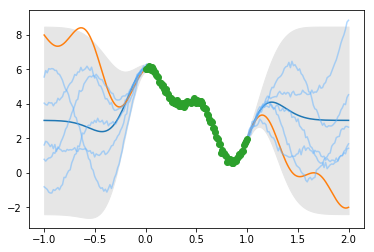

In [10]:
# Show prediction
x_test = x_test.flatten()
plt.figure()
plt.fill_between(x_test, mu - unc, mu + unc, color=(0.9,) * 3)
plt.plot(x_test, mu)
plt.plot(x_test, f(x_test))
for y_samp_i in y_samp:
    plt.plot(x_test, y_samp_i, color=(0.4, 0.7, 1.0), alpha=0.5)
plt.plot(x, y, 'o')
plt.show()